In [1]:
print("strawberry")

# loss function and metrics
from trustworthai.utils.losses_and_metrics.dice_loss import DiceLossWithWeightedEmptySlices
from trustworthai.utils.losses_and_metrics.dice_loss_metric import DiceLossMetric

# predefined training dataset
from trustworthai.utils.data_preprep.dataset_pipelines import load_data

# fitter
from trustworthai.utils.fitting_and_inference.fitters.basic_lightning_fitter import StandardLitModelWrapper
from trustworthai.utils.fitting_and_inference.get_trainer import get_trainer

# model
from trustworthai.journal_run.model_load.load_deterministic import load_deterministic

# optimizer and lr scheduler
import torch

# misc
import argparse
import os
import shutil
import matplotlib.pyplot as plt

print("banana")

strawberry
running on local machine!
banana


In [2]:
%load_ext autoreload

In [36]:
class ARGS():
    def __init__(self):
    
        # folder arguments
        self.ckpt_dir = '.'
        self.model_name = "test"
        
        # data generation arguments
        self.dataset = 'chal'
        self.seed = 3407
        self.test_split = 0.15
        self.val_split = 0.15
        self.empty_slice_retention = 0.1
        
        # general arguments for the loss function
        self.loss_name = 'dice+xent'#'dicev2'#'dice+xent'
        self.dice_factor = 1#5
        self.xent_factor = 1#0.01
        self.xent_weight = 'none'
        self.xent_reweighting=None,
        self.dice_empty_slice_weight = 0.5
        self.tversky_beta = 0.7
        self.reduction = 'mean'#'mean_sum'
        
        # training paradigm arguments
        self.lr = 2e-4
        self.dropout_p = 0.0
        self.max_epochs = 100
        self.early_stop_patience = 15
        self.batch_size = 8#32
        self.cross_validate = False
        self.cv_split = 0
        self.cv_test_fold_smooth = 1
        self.weight_decay = 0.0001
        self.overwrite = "true"

In [37]:
args = ARGS()
args.overwrite = True if args.overwrite.lower() == "true" else False
args.cross_validate = True

In [38]:
VOXELS_TO_WMH_RATIO = 382
VOXELS_TO_WMH_RATIO_EXCLUDING_EMPTY_SLICES = 140

XENT_VOXEL_RESCALE = VOXELS_TO_WMH_RATIO - (1-args.empty_slice_retention) * (VOXELS_TO_WMH_RATIO - VOXELS_TO_WMH_RATIO_EXCLUDING_EMPTY_SLICES)

XENT_WEIGHTING = XENT_VOXEL_RESCALE/2
args.xent_reweighting = XENT_WEIGHTING
args.xent_reweighting * 2

164.2

In [39]:
model_dir = os.path.join(args.ckpt_dir, args.model_name) # TODO model name dir goes here

In [40]:
if os.path.exists(model_dir):
    if not args.overwrite:
        raise ValueError(f"model directly ALREADY EXISTS: do not wish to overwrite!!: {model_dir}")
    else:
        print("warning, folder being overwritten")
        shutil.rmtree(model_dir)
        os.mkdir(model_dir)

warning, folder being overwritten


In [41]:
# get the 2d axial slice dataloaders
train_dl, val_dl, test_dl =  load_data(
    dataset=args.dataset, 
    test_proportion=args.test_split, 
    validation_proportion=args.val_split,
    seed=args.seed,
    empty_proportion_retained=args.empty_slice_retention,
    batch_size=args.batch_size,
    dataloader2d_only=True,
    cross_validate=args.cross_validate,
    cv_split=args.cv_split,
    cv_test_fold_smooth=args.cv_test_fold_smooth,
    merge_val_test="false"
)

39 9 12


In [42]:
wmh_voxel_count = 0
voxel_count = 0
for batch_train in train_dl:
    label_voxels = batch_train[1].view(-1)
    wmh_voxel_count += (label_voxels==1).sum().item()
    voxel_count += label_voxels.shape[0]

In [43]:
voxel_count/(wmh_voxel_count)

170.4063725985612

In [44]:
model_raw, loss, val_loss = load_deterministic(args)

In [45]:
# setup optimizer and model wrapper
optimizer_params={"lr":args.lr, "weight_decay":args.weight_decay}
optimizer = torch.optim.Adam
lr_scheduler_params={"milestones":[1000], "gamma":0.5}
lr_scheduler_constructor = torch.optim.lr_scheduler.MultiStepLR

In [46]:
# wrap the model in the pytorch_lightning module that automates training
model = StandardLitModelWrapper(model=model_raw, loss=loss, 
                                val_loss=val_loss,
                                logging_metric=lambda : None,
                                optimizer_params=optimizer_params,
                                lr_scheduler_params=lr_scheduler_params,
                                optimizer_constructor=optimizer,
                                lr_scheduler_constructor=lr_scheduler_constructor
                               )

In [47]:
# train the model
trainer = get_trainer(args.max_epochs, model_dir, early_stop_patience=args.early_stop_patience)
trainer.fit(model, train_dl, val_dl)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: test/lightning_logs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type           | Params
-----------------------------------------
0 | model | Deterministic  | 6.3 M 
1 | loss  | dice_xent_loss | 0     
-----------------------------------------
6.3 M     Trainable params
0         Non-trainable params
6.3 M     Total params
25.231    Total estimated model params size (MB)


running on local machine!


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved. New best score: 2.068


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.625 >= min_delta = 0.01. New best score: 1.443


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.121 >= min_delta = 0.01. New best score: 1.322


In [48]:
# get best checkpoint based on loss on validation data
try:
    #"save best model checkpoint name"
    with open(os.path.join(model_dir, "best_ckpt.txt"), "w") as f:
        f.write(trainer.checkpoint_callback.best_model_path)
        f.write("\n")
        for key , value in vars(args).items():
            f.write(f"{key}: {value}\n")
        
    trainer.validate(model, val_dl, ckpt_path='best')
except:
    print("failed to run validate to print best checkpoint path oh well")

Restoring states from the checkpoint path at /home/benp/Documents/PhD_projects/WMH_uncertainty_exploration/trustworthai/journal_run/training/new_scripts/testing_notebooks/test/epoch=2-step=390.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/benp/Documents/PhD_projects/WMH_uncertainty_exploration/trustworthai/journal_run/training/new_scripts/testing_notebooks/test/epoch=2-step=390.ckpt


Validation: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         val_loss          │    1.3220247030258179     │
└───────────────────────────┴───────────────────────────┘

### compare the loss implementations

In [49]:
import torch.nn as nn
class CrossEntropyCustomLog(nn.Module):
    def __init__(self, log, reduction='mean', weight=1., apply_softmax=True):
        super().__init__()
        log = str(log)
        if log == "10":
            self.log_func = torch.log10
        elif log == "2":
            self.log_func = torch.log2
        
        elif log == "e":
            self.log_func = torch.log
        self.nllloss = nn.NLLLoss(reduction=reduction)
        self.apply_softmax=True
        self.weight=weight
            
    def forward(self, predictions, targets):
        print(predictions.shape, targets.shape)
        targets = targets.type(torch.long)
        if self.apply_softmax:
            predictions = torch.softmax(predictions, dim=1)
        
        predictions = self.log_func(predictions)
        # targets = targets.argmax(dim=1)
        
        print(predictions.shape, targets.shape)
        
        return self.nllloss(predictions, targets) * self.weight

In [50]:
def xent_loss(weight, reduction):
    if reduction == "mean_sum":
        return mean_sum_xent_loss(weight)
    else:
        return torch.nn.CrossEntropyLoss(weight=weight, reduction=reduction)

In [51]:
batch = next(iter(train_dl))

In [52]:
with torch.no_grad():
    o = model.cuda()(batch[0].cuda())

In [53]:
o.shape

torch.Size([8, 2, 224, 160])

In [54]:
loss1 = xent_loss(weight=None, reduction='mean')
loss2 = CrossEntropyCustomLog(log="e", reduction='mean', weight=1., apply_softmax=True)

In [55]:
loss1(o, batch[1].cuda()), loss2(o, batch[1].cuda()), 

torch.Size([8, 2, 224, 160]) torch.Size([8, 224, 160])
torch.Size([8, 2, 224, 160]) torch.Size([8, 224, 160])


(tensor(0.0135, device='cuda:0'), tensor(0.0135, device='cuda:0'))

In [56]:
from trustworthai.utils.losses_and_metrics.dice_loss import DiceLossWithWeightedEmptySlices, SoftDiceV2, SoftDiceV1

In [57]:
loss_dice2 = SoftDiceV2()
loss_dice1 = SoftDiceV1()

In [58]:
loss_dice1(o, batch[1].cuda()), loss_dice2(o, batch[1].cuda()), 

(tensor(0.5421, device='cuda:0'), tensor(0.3654, device='cuda:0'))

In [60]:
loss1(o, batch[1].cuda()) * args.xent_reweighting, loss_dice2(o, batch[1].cuda()), loss1(o, batch[1].cuda()) * args.xent_reweighting + loss_dice2(o, batch[1].cuda()), loss(o, batch[1].cuda())

(tensor(1.1074, device='cuda:0'),
 tensor(0.3654, device='cuda:0'),
 tensor(1.4727, device='cuda:0'),
 tensor(1.4727, device='cuda:0'))

(-0.5, 159.5, 223.5, -0.5)

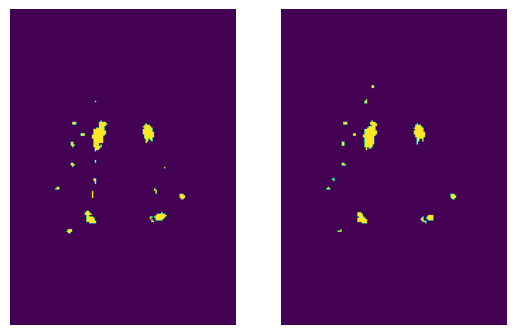

In [29]:
plt.subplot(1,2,1)
plt.imshow(o[3].argmax(dim=0).cpu())
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(batch[1][3])
plt.axis('off')

In [24]:
batch[1][0].shape

torch.Size([224, 160])